## NN Adv Assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
'''
### TensorFlow

import tensorflow as tf
from tensorflow import keras
'''
import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [3]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [4]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train['label'].nunique()

10

In [6]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
test['label'].unique()

array([0, 1, 2, 3, 8, 6, 5, 4, 7, 9])

In [7]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

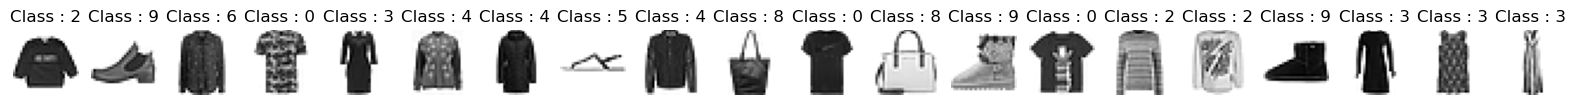

In [8]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [9]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

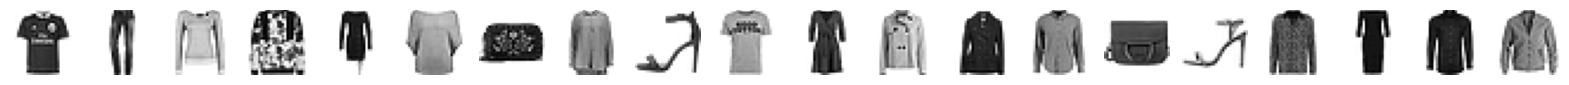

In [10]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [12]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cpu


In [13]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 128
#Epoch는 고정해주세요.
EPOCHS = 15

In [17]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [18]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [19]:
def train(model, train_loader,optimizer, criterion):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

In [20]:
class MyNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #여기에 layer들을 삽입: self.layer1 와 같이 Data Attribute로 nn 모듈의 Network 추가
        #Ex. self.layer1 = nn.Linear(100, 10)
        #자세한 것은 pytorch 공식문서 혹은 인터넷 예제 참고
        self.layer1 = nn.Linear(784,512)
        self.layer2 = nn.Linear(512,256)
        self.layer3 = nn.Linear(256,64)
        self.layer4 = nn.Linear(64,10)

        # batch norm 사용
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(64)

        # 가중치를 relu에 성능이 좋은 he init으로 초기화
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight.data)
        
    def forward(self, x):
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)
        x = self.bn1(F.relu(self.layer1(x)))
        x = self.bn2(F.relu(self.layer2(x)))
        x = self.bn3(F.relu(self.layer3(x)))
        x = self.layer4(x)

        return x
    
model = MyNet().to(DEVICE)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-2)
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.4607, 	Train Accuracy: 83.74 %, 	Val Loss: 0.3670, 	Val Accuracy: 86.66 % 

[EPOCH: 2], 	Train Loss: 0.3563, 	Train Accuracy: 86.99 %, 	Val Loss: 0.3947, 	Val Accuracy: 85.02 % 

[EPOCH: 3], 	Train Loss: 0.3216, 	Train Accuracy: 88.18 %, 	Val Loss: 0.3426, 	Val Accuracy: 87.41 % 

[EPOCH: 4], 	Train Loss: 0.3018, 	Train Accuracy: 88.87 %, 	Val Loss: 0.3348, 	Val Accuracy: 87.78 % 

[EPOCH: 5], 	Train Loss: 0.2851, 	Train Accuracy: 89.44 %, 	Val Loss: 0.3481, 	Val Accuracy: 87.22 % 

[EPOCH: 6], 	Train Loss: 0.2751, 	Train Accuracy: 89.78 %, 	Val Loss: 0.3423, 	Val Accuracy: 87.66 % 

[EPOCH: 7], 	Train Loss: 0.2565, 	Train Accuracy: 90.32 %, 	Val Loss: 0.3181, 	Val Accuracy: 88.34 % 

[EPOCH: 8], 	Train Loss: 0.2470, 	Train Accuracy: 90.78 %, 	Val Loss: 0.3493, 	Val Accuracy: 87.13 % 

[EPOCH: 9], 	Train Loss: 0.2339, 	Train Accuracy: 91.14 %, 	Val Loss: 0.3220, 	Val Accuracy: 88.28 % 

[EPOCH: 10], 	Train Loss: 0.2244, 	Train Accuracy: 91.45 %, 	Val Loss: 0.

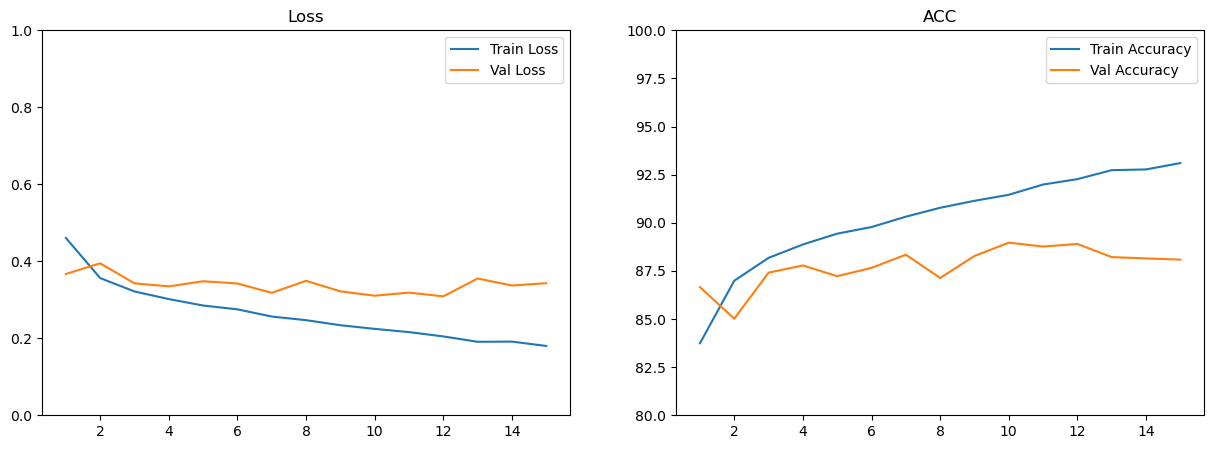

In [21]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader,optimizer, criterion)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## 결론을 작성해주세요:

In [ ]:
'''
Regularization: L2 regularization을 통해 overfitting 방지
Optimization: 가장성능이 좋은 Adam을 사용하지만, L2 regularization를 같이 사용했을 때 Adam을 올바르게 쓸 수 있는 AdamW를 이용
Initialization: relu를 썼을 때 효과적인 kaiming he의 he initialization 사용
normalization: batch normalization을 이용

train loss는 지속적으로 감소했으나 val loss는 일정 수준에서 멈추는 모습을 보였음
Layer의 갯수를 줄이거나 regularization을 더 강하게 하는 등 실험을 통해 성능 향상을 할 수 있을 것이라고 생각함
Convolution을 통해 image 도메인에 맞는 network구성도 좋아 보임
'''